<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:59] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


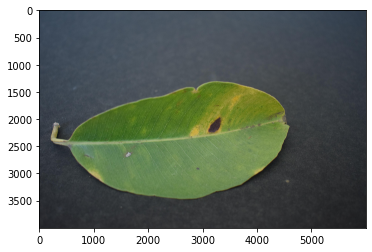

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

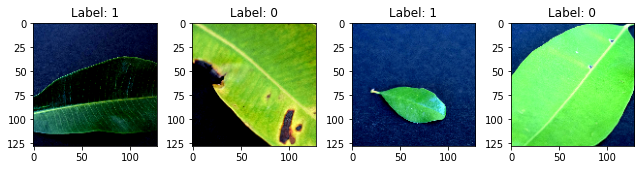

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:10:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:10:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2577860731130377 samples/sec                   batch loss = 0.34762057662010193 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.259040045543088 samples/sec                   batch loss = 0.9554293751716614 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.214725553899612 samples/sec                   batch loss = 0.631466805934906 | accuracy = 0.43333333333333335


Epoch[1] Batch[20] Speed: 1.2651788017673513 samples/sec                   batch loss = 1.1362744569778442 | accuracy = 0.4625


Epoch[1] Batch[25] Speed: 1.2649554915114791 samples/sec                   batch loss = 0.7676012516021729 | accuracy = 0.48


Epoch[1] Batch[30] Speed: 1.2551738502255798 samples/sec                   batch loss = 0.6241964101791382 | accuracy = 0.5166666666666667


Epoch[1] Batch[35] Speed: 1.2567689700043065 samples/sec                   batch loss = 0.23845821619033813 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.261144697521229 samples/sec                   batch loss = 0.9994935989379883 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2595943448192914 samples/sec                   batch loss = 0.35997405648231506 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2614762066634893 samples/sec                   batch loss = 0.28947076201438904 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2802568874827636 samples/sec                   batch loss = 0.22879855334758759 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.2904872767069238 samples/sec                   batch loss = 0.6546086668968201 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2837527672600046 samples/sec                   batch loss = 2.4498870372772217 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.2831351995774587 samples/sec                   batch loss = 0.16824223101139069 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.2859384589371496 samples/sec                   batch loss = 0.48722219467163086 | accuracy = 0.62


Epoch[1] Batch[80] Speed: 1.2905169570375767 samples/sec                   batch loss = 0.09286104887723923 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.2890181706426953 samples/sec                   batch loss = 0.7170626521110535 | accuracy = 0.6205882352941177


Epoch[1] Batch[90] Speed: 1.286817663498407 samples/sec                   batch loss = 0.510304868221283 | accuracy = 0.6194444444444445


Epoch[1] Batch[95] Speed: 1.2916329943350415 samples/sec                   batch loss = 0.8147669434547424 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.29181340254742 samples/sec                   batch loss = 0.533821165561676 | accuracy = 0.62


Epoch[1] Batch[105] Speed: 1.2946730334816487 samples/sec                   batch loss = 0.7159988880157471 | accuracy = 0.6238095238095238


Epoch[1] Batch[110] Speed: 1.299316165935183 samples/sec                   batch loss = 0.4292162358760834 | accuracy = 0.6272727272727273


Epoch[1] Batch[115] Speed: 1.2960445233495903 samples/sec                   batch loss = 0.4046943485736847 | accuracy = 0.6369565217391304


Epoch[1] Batch[120] Speed: 1.2884953675205812 samples/sec                   batch loss = 1.0325154066085815 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2984979891225394 samples/sec                   batch loss = 0.8405129313468933 | accuracy = 0.63


Epoch[1] Batch[130] Speed: 1.2938599934571338 samples/sec                   batch loss = 0.38397473096847534 | accuracy = 0.6384615384615384


Epoch[1] Batch[135] Speed: 1.303997890872552 samples/sec                   batch loss = 0.5385623574256897 | accuracy = 0.6444444444444445


Epoch[1] Batch[140] Speed: 1.2947017077155727 samples/sec                   batch loss = 0.9957665801048279 | accuracy = 0.6428571428571429


Epoch[1] Batch[145] Speed: 1.2934704598418327 samples/sec                   batch loss = 0.8191912770271301 | accuracy = 0.6344827586206897


Epoch[1] Batch[150] Speed: 1.2921056036474539 samples/sec                   batch loss = 1.724202275276184 | accuracy = 0.635


Epoch[1] Batch[155] Speed: 1.2869121256750122 samples/sec                   batch loss = 1.066194772720337 | accuracy = 0.6370967741935484


Epoch[1] Batch[160] Speed: 1.288170771914323 samples/sec                   batch loss = 0.39087918400764465 | accuracy = 0.6375


Epoch[1] Batch[165] Speed: 1.2866355890310148 samples/sec                   batch loss = 0.4452252984046936 | accuracy = 0.6424242424242425


Epoch[1] Batch[170] Speed: 1.2892149875287326 samples/sec                   batch loss = 1.0387481451034546 | accuracy = 0.6411764705882353


Epoch[1] Batch[175] Speed: 1.289802328441086 samples/sec                   batch loss = 0.6623556613922119 | accuracy = 0.6385714285714286


Epoch[1] Batch[180] Speed: 1.2907757002773859 samples/sec                   batch loss = 0.47299179434776306 | accuracy = 0.6375


Epoch[1] Batch[185] Speed: 1.2870019615078065 samples/sec                   batch loss = 0.344941109418869 | accuracy = 0.6391891891891892


Epoch[1] Batch[190] Speed: 1.2844795872813581 samples/sec                   batch loss = 0.6156676411628723 | accuracy = 0.6368421052631579


Epoch[1] Batch[195] Speed: 1.2875460817300737 samples/sec                   batch loss = 0.7852707505226135 | accuracy = 0.632051282051282


Epoch[1] Batch[200] Speed: 1.287798890113874 samples/sec                   batch loss = 0.5936896204948425 | accuracy = 0.63375


Epoch[1] Batch[205] Speed: 1.2883311201025982 samples/sec                   batch loss = 0.3261292576789856 | accuracy = 0.6341463414634146


Epoch[1] Batch[210] Speed: 1.2884065104046873 samples/sec                   batch loss = 0.8757240176200867 | accuracy = 0.6321428571428571


Epoch[1] Batch[215] Speed: 1.2894729115795898 samples/sec                   batch loss = 0.764534056186676 | accuracy = 0.6325581395348837


Epoch[1] Batch[220] Speed: 1.2873878058312385 samples/sec                   batch loss = 0.9967533349990845 | accuracy = 0.6329545454545454


Epoch[1] Batch[225] Speed: 1.2861630280535092 samples/sec                   batch loss = 0.7534011006355286 | accuracy = 0.6377777777777778


Epoch[1] Batch[230] Speed: 1.2920295808354827 samples/sec                   batch loss = 0.3626543879508972 | accuracy = 0.6391304347826087


Epoch[1] Batch[235] Speed: 1.289183385800585 samples/sec                   batch loss = 0.8808282017707825 | accuracy = 0.6425531914893617


Epoch[1] Batch[240] Speed: 1.2918065393505063 samples/sec                   batch loss = 0.9403244853019714 | accuracy = 0.6416666666666667


Epoch[1] Batch[245] Speed: 1.2890433265725443 samples/sec                   batch loss = 0.4405474066734314 | accuracy = 0.6428571428571429


Epoch[1] Batch[250] Speed: 1.287344637450297 samples/sec                   batch loss = 0.5595066547393799 | accuracy = 0.643


Epoch[1] Batch[255] Speed: 1.2904924384054897 samples/sec                   batch loss = 0.6532291769981384 | accuracy = 0.6460784313725491


Epoch[1] Batch[260] Speed: 1.292605845813069 samples/sec                   batch loss = 0.3108615577220917 | accuracy = 0.6451923076923077


Epoch[1] Batch[265] Speed: 1.2915839725861618 samples/sec                   batch loss = 0.8117524981498718 | accuracy = 0.6481132075471698


Epoch[1] Batch[270] Speed: 1.293288093114927 samples/sec                   batch loss = 1.203747034072876 | accuracy = 0.65


Epoch[1] Batch[275] Speed: 1.291542809123716 samples/sec                   batch loss = 0.7533656358718872 | accuracy = 0.649090909090909


Epoch[1] Batch[280] Speed: 1.288737065458197 samples/sec                   batch loss = 0.7501530647277832 | accuracy = 0.6482142857142857


Epoch[1] Batch[285] Speed: 1.2680971735258701 samples/sec                   batch loss = 0.7171066403388977 | accuracy = 0.6464912280701754


Epoch[1] Batch[290] Speed: 1.2641181843738258 samples/sec                   batch loss = 1.1014008522033691 | accuracy = 0.6456896551724138


Epoch[1] Batch[295] Speed: 1.2624617106997538 samples/sec                   batch loss = 0.7210419178009033 | accuracy = 0.6449152542372881


Epoch[1] Batch[300] Speed: 1.2665493869767002 samples/sec                   batch loss = 0.4128628969192505 | accuracy = 0.6466666666666666


Epoch[1] Batch[305] Speed: 1.2655028896798464 samples/sec                   batch loss = 0.41165828704833984 | accuracy = 0.6475409836065574


Epoch[1] Batch[310] Speed: 1.266631334018847 samples/sec                   batch loss = 0.32492348551750183 | accuracy = 0.6475806451612903


Epoch[1] Batch[315] Speed: 1.2632552562736716 samples/sec                   batch loss = 0.6265950202941895 | accuracy = 0.6452380952380953


Epoch[1] Batch[320] Speed: 1.2639658060855663 samples/sec                   batch loss = 0.5778688788414001 | accuracy = 0.64453125


Epoch[1] Batch[325] Speed: 1.2667153957356856 samples/sec                   batch loss = 0.5598576664924622 | accuracy = 0.6476923076923077


Epoch[1] Batch[330] Speed: 1.267370483724089 samples/sec                   batch loss = 0.4470147490501404 | accuracy = 0.65


Epoch[1] Batch[335] Speed: 1.2673524851142577 samples/sec                   batch loss = 0.914052426815033 | accuracy = 0.6485074626865671


Epoch[1] Batch[340] Speed: 1.269763865711769 samples/sec                   batch loss = 0.5198670029640198 | accuracy = 0.6477941176470589


Epoch[1] Batch[345] Speed: 1.2681625455505015 samples/sec                   batch loss = 0.5075616240501404 | accuracy = 0.6492753623188405


Epoch[1] Batch[350] Speed: 1.2652492166483447 samples/sec                   batch loss = 0.4471204876899719 | accuracy = 0.65


Epoch[1] Batch[355] Speed: 1.264463266484784 samples/sec                   batch loss = 0.8414638042449951 | accuracy = 0.65


Epoch[1] Batch[360] Speed: 1.2632540197419582 samples/sec                   batch loss = 0.5613786578178406 | accuracy = 0.6520833333333333


Epoch[1] Batch[365] Speed: 1.2660132159604203 samples/sec                   batch loss = 0.7988479137420654 | accuracy = 0.6527397260273973


Epoch[1] Batch[370] Speed: 1.2684907536024916 samples/sec                   batch loss = 1.577236533164978 | accuracy = 0.6533783783783784


Epoch[1] Batch[375] Speed: 1.2704997497199968 samples/sec                   batch loss = 0.5687193274497986 | accuracy = 0.652


Epoch[1] Batch[380] Speed: 1.26835400357587 samples/sec                   batch loss = 0.7219692468643188 | accuracy = 0.65


Epoch[1] Batch[385] Speed: 1.2764528261003205 samples/sec                   batch loss = 0.42154914140701294 | accuracy = 0.6512987012987013


Epoch[1] Batch[390] Speed: 1.267531823879034 samples/sec                   batch loss = 0.402767151594162 | accuracy = 0.6538461538461539


Epoch[1] Batch[395] Speed: 1.2638543075053463 samples/sec                   batch loss = 0.6717479825019836 | accuracy = 0.6550632911392406


Epoch[1] Batch[400] Speed: 1.2685199102966773 samples/sec                   batch loss = 0.8523503541946411 | accuracy = 0.65375


Epoch[1] Batch[405] Speed: 1.2614633071687893 samples/sec                   batch loss = 0.38326483964920044 | accuracy = 0.6561728395061729


Epoch[1] Batch[410] Speed: 1.2677434955024665 samples/sec                   batch loss = 1.2864480018615723 | accuracy = 0.6554878048780488


Epoch[1] Batch[415] Speed: 1.2643868405680496 samples/sec                   batch loss = 0.80650794506073 | accuracy = 0.6566265060240963


Epoch[1] Batch[420] Speed: 1.2627737627336078 samples/sec                   batch loss = 0.5925508737564087 | accuracy = 0.6553571428571429


Epoch[1] Batch[425] Speed: 1.2621654800492852 samples/sec                   batch loss = 0.47144562005996704 | accuracy = 0.6564705882352941


Epoch[1] Batch[430] Speed: 1.2641098978598488 samples/sec                   batch loss = 0.23150427639484406 | accuracy = 0.6558139534883721


Epoch[1] Batch[435] Speed: 1.2622268232348461 samples/sec                   batch loss = 0.46719712018966675 | accuracy = 0.6557471264367816


Epoch[1] Batch[440] Speed: 1.2669572190522478 samples/sec                   batch loss = 0.9129804372787476 | accuracy = 0.6556818181818181


Epoch[1] Batch[445] Speed: 1.2629452479596248 samples/sec                   batch loss = 0.3935243487358093 | accuracy = 0.6561797752808989


Epoch[1] Batch[450] Speed: 1.2618585688134283 samples/sec                   batch loss = 0.44264113903045654 | accuracy = 0.6583333333333333


Epoch[1] Batch[455] Speed: 1.2670318508992247 samples/sec                   batch loss = 0.37922602891921997 | accuracy = 0.6565934065934066


Epoch[1] Batch[460] Speed: 1.2649382290293592 samples/sec                   batch loss = 0.4885728061199188 | accuracy = 0.6581521739130435


Epoch[1] Batch[465] Speed: 1.2641040878401262 samples/sec                   batch loss = 0.5900024175643921 | accuracy = 0.6580645161290323


Epoch[1] Batch[470] Speed: 1.263596250909914 samples/sec                   batch loss = 0.5935510396957397 | accuracy = 0.6574468085106383


Epoch[1] Batch[475] Speed: 1.262970442340349 samples/sec                   batch loss = 0.7395071387290955 | accuracy = 0.6568421052631579


Epoch[1] Batch[480] Speed: 1.266787607825063 samples/sec                   batch loss = 0.41435468196868896 | accuracy = 0.65625


Epoch[1] Batch[485] Speed: 1.261315835373225 samples/sec                   batch loss = 0.6687577366828918 | accuracy = 0.6556701030927835


Epoch[1] Batch[490] Speed: 1.2744583735592452 samples/sec                   batch loss = 0.7406139373779297 | accuracy = 0.6556122448979592


Epoch[1] Batch[495] Speed: 1.2661582527256163 samples/sec                   batch loss = 0.2710004448890686 | accuracy = 0.656060606060606


Epoch[1] Batch[500] Speed: 1.265228129527165 samples/sec                   batch loss = 0.2792055606842041 | accuracy = 0.6555


Epoch[1] Batch[505] Speed: 1.2644968129467973 samples/sec                   batch loss = 0.4592059850692749 | accuracy = 0.657920792079208


Epoch[1] Batch[510] Speed: 1.2599949651919324 samples/sec                   batch loss = 0.1332075446844101 | accuracy = 0.657843137254902


Epoch[1] Batch[515] Speed: 1.2687935114113564 samples/sec                   batch loss = 0.6877588033676147 | accuracy = 0.6577669902912622


Epoch[1] Batch[520] Speed: 1.2569772502558763 samples/sec                   batch loss = 0.5499886274337769 | accuracy = 0.6572115384615385


Epoch[1] Batch[525] Speed: 1.2641787649485876 samples/sec                   batch loss = 0.6114625930786133 | accuracy = 0.6585714285714286


Epoch[1] Batch[530] Speed: 1.2644855670594934 samples/sec                   batch loss = 0.5370035171508789 | accuracy = 0.6584905660377358


Epoch[1] Batch[535] Speed: 1.2524079821934466 samples/sec                   batch loss = 0.303740918636322 | accuracy = 0.6598130841121496


Epoch[1] Batch[540] Speed: 1.2600995373435533 samples/sec                   batch loss = 0.5927025079727173 | accuracy = 0.6611111111111111


Epoch[1] Batch[545] Speed: 1.261318964641648 samples/sec                   batch loss = 0.3768758177757263 | accuracy = 0.6619266055045872


Epoch[1] Batch[550] Speed: 1.2636569718251884 samples/sec                   batch loss = 0.40399929881095886 | accuracy = 0.6618181818181819


Epoch[1] Batch[555] Speed: 1.2639404767563984 samples/sec                   batch loss = 0.3841545879840851 | accuracy = 0.6621621621621622


Epoch[1] Batch[560] Speed: 1.258271979895507 samples/sec                   batch loss = 0.1987851858139038 | accuracy = 0.6642857142857143


Epoch[1] Batch[565] Speed: 1.2599998858451946 samples/sec                   batch loss = 0.676877498626709 | accuracy = 0.6650442477876106


Epoch[1] Batch[570] Speed: 1.2649065664746701 samples/sec                   batch loss = 0.41184231638908386 | accuracy = 0.6649122807017543


Epoch[1] Batch[575] Speed: 1.257376961211503 samples/sec                   batch loss = 0.7373367547988892 | accuracy = 0.6652173913043479


Epoch[1] Batch[580] Speed: 1.2550849286641115 samples/sec                   batch loss = 1.3822152614593506 | accuracy = 0.665948275862069


Epoch[1] Batch[585] Speed: 1.2599057377052258 samples/sec                   batch loss = 0.2195509374141693 | accuracy = 0.6645299145299145


Epoch[1] Batch[590] Speed: 1.2588388263604375 samples/sec                   batch loss = 0.42531466484069824 | accuracy = 0.6627118644067796


Epoch[1] Batch[595] Speed: 1.2574600817589614 samples/sec                   batch loss = 0.15785682201385498 | accuracy = 0.6630252100840336


Epoch[1] Batch[600] Speed: 1.26112962444574 samples/sec                   batch loss = 0.6224491596221924 | accuracy = 0.6629166666666667


Epoch[1] Batch[605] Speed: 1.2567151221474369 samples/sec                   batch loss = 0.9209848642349243 | accuracy = 0.6632231404958677


Epoch[1] Batch[610] Speed: 1.2573440741425503 samples/sec                   batch loss = 0.9761702418327332 | accuracy = 0.6639344262295082


Epoch[1] Batch[615] Speed: 1.2597596703537397 samples/sec                   batch loss = 0.516568660736084 | accuracy = 0.6630081300813008


Epoch[1] Batch[620] Speed: 1.2622192262320342 samples/sec                   batch loss = 0.8381288647651672 | accuracy = 0.6633064516129032


Epoch[1] Batch[625] Speed: 1.2657810161396508 samples/sec                   batch loss = 0.5339483022689819 | accuracy = 0.6644


Epoch[1] Batch[630] Speed: 1.2667608262221628 samples/sec                   batch loss = 0.5870245695114136 | accuracy = 0.6654761904761904


Epoch[1] Batch[635] Speed: 1.2668539928228892 samples/sec                   batch loss = 0.965904712677002 | accuracy = 0.6645669291338583


Epoch[1] Batch[640] Speed: 1.260961475067677 samples/sec                   batch loss = 0.4365227222442627 | accuracy = 0.66484375


Epoch[1] Batch[645] Speed: 1.2624104136193797 samples/sec                   batch loss = 0.7053042650222778 | accuracy = 0.665891472868217


Epoch[1] Batch[650] Speed: 1.2601308650498864 samples/sec                   batch loss = 0.7353801131248474 | accuracy = 0.665


Epoch[1] Batch[655] Speed: 1.2529016244048383 samples/sec                   batch loss = 0.7862487435340881 | accuracy = 0.6648854961832061


Epoch[1] Batch[660] Speed: 1.2568822350145488 samples/sec                   batch loss = 0.6731149554252625 | accuracy = 0.6651515151515152


Epoch[1] Batch[665] Speed: 1.262709420261495 samples/sec                   batch loss = 0.3074193298816681 | accuracy = 0.6650375939849624


Epoch[1] Batch[670] Speed: 1.2638426922177008 samples/sec                   batch loss = 0.3995025157928467 | accuracy = 0.6664179104477612


Epoch[1] Batch[675] Speed: 1.2611108547044911 samples/sec                   batch loss = 0.4095955789089203 | accuracy = 0.6677777777777778


Epoch[1] Batch[680] Speed: 1.2625441747434363 samples/sec                   batch loss = 0.9447720050811768 | accuracy = 0.6676470588235294


Epoch[1] Batch[685] Speed: 1.258563458740212 samples/sec                   batch loss = 0.9576879143714905 | accuracy = 0.6667883211678832


Epoch[1] Batch[690] Speed: 1.2640248483125671 samples/sec                   batch loss = 0.555091917514801 | accuracy = 0.6670289855072464


Epoch[1] Batch[695] Speed: 1.262393125542654 samples/sec                   batch loss = 0.39899295568466187 | accuracy = 0.6679856115107914


Epoch[1] Batch[700] Speed: 1.2632835069268489 samples/sec                   batch loss = 0.9935808181762695 | accuracy = 0.6675


Epoch[1] Batch[705] Speed: 1.257615797435987 samples/sec                   batch loss = 0.5412969589233398 | accuracy = 0.6677304964539007


Epoch[1] Batch[710] Speed: 1.2642011507495816 samples/sec                   batch loss = 0.40920841693878174 | accuracy = 0.6679577464788733


Epoch[1] Batch[715] Speed: 1.2675648629831928 samples/sec                   batch loss = 0.28487181663513184 | accuracy = 0.6692307692307692


Epoch[1] Batch[720] Speed: 1.2597928731047408 samples/sec                   batch loss = 0.2870526611804962 | accuracy = 0.6690972222222222


Epoch[1] Batch[725] Speed: 1.2684971794692854 samples/sec                   batch loss = 0.6080420017242432 | accuracy = 0.67


Epoch[1] Batch[730] Speed: 1.262780510994637 samples/sec                   batch loss = 0.4429791271686554 | accuracy = 0.6705479452054794


Epoch[1] Batch[735] Speed: 1.261554652653216 samples/sec                   batch loss = 0.7606741786003113 | accuracy = 0.6710884353741496


Epoch[1] Batch[740] Speed: 1.2665419290792457 samples/sec                   batch loss = 0.5514277815818787 | accuracy = 0.6712837837837838


Epoch[1] Batch[745] Speed: 1.273523850615306 samples/sec                   batch loss = 0.4796704649925232 | accuracy = 0.6714765100671141


Epoch[1] Batch[750] Speed: 1.2647231074533425 samples/sec                   batch loss = 0.3742932975292206 | accuracy = 0.6713333333333333


Epoch[1] Batch[755] Speed: 1.265316967360039 samples/sec                   batch loss = 0.7464851140975952 | accuracy = 0.6705298013245033


Epoch[1] Batch[760] Speed: 1.2609134270858033 samples/sec                   batch loss = 0.45396384596824646 | accuracy = 0.6700657894736842


Epoch[1] Batch[765] Speed: 1.2606236057954427 samples/sec                   batch loss = 0.3630349636077881 | accuracy = 0.6722222222222223


Epoch[1] Batch[770] Speed: 1.2626030842278695 samples/sec                   batch loss = 0.35166484117507935 | accuracy = 0.672077922077922


Epoch[1] Batch[775] Speed: 1.2677540330411272 samples/sec                   batch loss = 0.9947574734687805 | accuracy = 0.6725806451612903


Epoch[1] Batch[780] Speed: 1.2613634398623006 samples/sec                   batch loss = 0.8703204989433289 | accuracy = 0.6714743589743589


Epoch[1] Batch[785] Speed: 1.2661432506762311 samples/sec                   batch loss = 0.5806384682655334 | accuracy = 0.6719745222929936


[Epoch 1] training: accuracy=0.6725888324873096
[Epoch 1] time cost: 648.4334101676941
[Epoch 1] validation: validation accuracy=0.7444444444444445


Epoch[2] Batch[5] Speed: 1.2680953524076042 samples/sec                   batch loss = 0.6795845627784729 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2636072906422788 samples/sec                   batch loss = 0.39784061908721924 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.266643000621045 samples/sec                   batch loss = 0.8907753229141235 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2659858939128497 samples/sec                   batch loss = 0.5918709635734558 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2696535518246503 samples/sec                   batch loss = 0.6285033822059631 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2689015645475117 samples/sec                   batch loss = 0.27102386951446533 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.269428467185428 samples/sec                   batch loss = 0.3525390028953552 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2629536142840119 samples/sec                   batch loss = 0.4465586543083191 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2703610271551034 samples/sec                   batch loss = 0.6383998990058899 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.2656640410970013 samples/sec                   batch loss = 0.36192935705184937 | accuracy = 0.76


Epoch[2] Batch[55] Speed: 1.2648554519604254 samples/sec                   batch loss = 0.9083406329154968 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2653773765777039 samples/sec                   batch loss = 0.530834972858429 | accuracy = 0.7625


Epoch[2] Batch[65] Speed: 1.268250933109072 samples/sec                   batch loss = 0.5787162184715271 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.2682953232656207 samples/sec                   batch loss = 0.27362126111984253 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.2732037581680127 samples/sec                   batch loss = 0.28374502062797546 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.267780186053056 samples/sec                   batch loss = 0.4462781846523285 | accuracy = 0.74375


Epoch[2] Batch[85] Speed: 1.2635561859154727 samples/sec                   batch loss = 0.4194697141647339 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.2651513249154382 samples/sec                   batch loss = 0.6127302646636963 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.261637377735098 samples/sec                   batch loss = 0.4525671601295471 | accuracy = 0.7342105263157894


Epoch[2] Batch[100] Speed: 1.2634911927656665 samples/sec                   batch loss = 0.965272068977356 | accuracy = 0.725


Epoch[2] Batch[105] Speed: 1.2694386485483626 samples/sec                   batch loss = 0.511942982673645 | accuracy = 0.7166666666666667


Epoch[2] Batch[110] Speed: 1.265338152874442 samples/sec                   batch loss = 0.4645519256591797 | accuracy = 0.7204545454545455


Epoch[2] Batch[115] Speed: 1.2689868877077166 samples/sec                   batch loss = 0.6091948747634888 | accuracy = 0.7217391304347827


Epoch[2] Batch[120] Speed: 1.264792518121461 samples/sec                   batch loss = 0.2905755341053009 | accuracy = 0.725


Epoch[2] Batch[125] Speed: 1.2663552234272624 samples/sec                   batch loss = 0.5052289366722107 | accuracy = 0.724


Epoch[2] Batch[130] Speed: 1.2632708558047252 samples/sec                   batch loss = 0.5425872802734375 | accuracy = 0.7307692307692307


Epoch[2] Batch[135] Speed: 1.2662009675139143 samples/sec                   batch loss = 0.8322508335113525 | accuracy = 0.7240740740740741


Epoch[2] Batch[140] Speed: 1.2684366638118325 samples/sec                   batch loss = 0.4262380599975586 | accuracy = 0.725


Epoch[2] Batch[145] Speed: 1.2696074332337128 samples/sec                   batch loss = 0.550999641418457 | accuracy = 0.7275862068965517


Epoch[2] Batch[150] Speed: 1.26270200751756 samples/sec                   batch loss = 0.5505039691925049 | accuracy = 0.725


Epoch[2] Batch[155] Speed: 1.2624013895642126 samples/sec                   batch loss = 0.4557425081729889 | accuracy = 0.7209677419354839


Epoch[2] Batch[160] Speed: 1.2601933358210884 samples/sec                   batch loss = 0.5347397327423096 | accuracy = 0.71875


Epoch[2] Batch[165] Speed: 1.2660750292800136 samples/sec                   batch loss = 0.6036325097084045 | accuracy = 0.7227272727272728


Epoch[2] Batch[170] Speed: 1.2631800224820111 samples/sec                   batch loss = 1.0039474964141846 | accuracy = 0.7220588235294118


Epoch[2] Batch[175] Speed: 1.2586306841612853 samples/sec                   batch loss = 0.4792827069759369 | accuracy = 0.7257142857142858


Epoch[2] Batch[180] Speed: 1.2647766902930675 samples/sec                   batch loss = 0.41316884756088257 | accuracy = 0.7277777777777777


Epoch[2] Batch[185] Speed: 1.2757506772561913 samples/sec                   batch loss = 0.311220645904541 | accuracy = 0.7283783783783784


Epoch[2] Batch[190] Speed: 1.267441525781417 samples/sec                   batch loss = 0.39548397064208984 | accuracy = 0.7302631578947368


Epoch[2] Batch[195] Speed: 1.2653005538456248 samples/sec                   batch loss = 0.492763489484787 | accuracy = 0.7256410256410256


Epoch[2] Batch[200] Speed: 1.268144141014422 samples/sec                   batch loss = 0.6815572381019592 | accuracy = 0.7275


Epoch[2] Batch[205] Speed: 1.2643732144735822 samples/sec                   batch loss = 0.7620891332626343 | accuracy = 0.7292682926829268


Epoch[2] Batch[210] Speed: 1.2643502508810283 samples/sec                   batch loss = 0.39995238184928894 | accuracy = 0.7297619047619047


Epoch[2] Batch[215] Speed: 1.2692530084131848 samples/sec                   batch loss = 0.32487863302230835 | accuracy = 0.7290697674418605


Epoch[2] Batch[220] Speed: 1.270820794078174 samples/sec                   batch loss = 0.2522248923778534 | accuracy = 0.7295454545454545


Epoch[2] Batch[225] Speed: 1.261352154807876 samples/sec                   batch loss = 0.5581749677658081 | accuracy = 0.7288888888888889


Epoch[2] Batch[230] Speed: 1.2681612035350227 samples/sec                   batch loss = 0.27272486686706543 | accuracy = 0.7293478260869565


Epoch[2] Batch[235] Speed: 1.2653272737378924 samples/sec                   batch loss = 0.7884441018104553 | accuracy = 0.7308510638297873


Epoch[2] Batch[240] Speed: 1.2708578555040269 samples/sec                   batch loss = 0.24181818962097168 | accuracy = 0.7291666666666666


Epoch[2] Batch[245] Speed: 1.265067566044205 samples/sec                   batch loss = 0.5364212989807129 | accuracy = 0.7306122448979592


Epoch[2] Batch[250] Speed: 1.2625801848880647 samples/sec                   batch loss = 0.7784721851348877 | accuracy = 0.732


Epoch[2] Batch[255] Speed: 1.2718425552418464 samples/sec                   batch loss = 0.46842125058174133 | accuracy = 0.7352941176470589


Epoch[2] Batch[260] Speed: 1.2662122439343804 samples/sec                   batch loss = 0.3365289568901062 | accuracy = 0.7384615384615385


Epoch[2] Batch[265] Speed: 1.267896019506167 samples/sec                   batch loss = 0.49317467212677 | accuracy = 0.7415094339622641


Epoch[2] Batch[270] Speed: 1.26314626054569 samples/sec                   batch loss = 0.7014623284339905 | accuracy = 0.737037037037037


Epoch[2] Batch[275] Speed: 1.2613994775225372 samples/sec                   batch loss = 0.6188890933990479 | accuracy = 0.7363636363636363


Epoch[2] Batch[280] Speed: 1.2614533481805517 samples/sec                   batch loss = 0.4028008282184601 | accuracy = 0.7357142857142858


Epoch[2] Batch[285] Speed: 1.2586506076810233 samples/sec                   batch loss = 0.45876768231391907 | accuracy = 0.7359649122807017


Epoch[2] Batch[290] Speed: 1.2590502499194203 samples/sec                   batch loss = 0.33516159653663635 | accuracy = 0.7353448275862069


Epoch[2] Batch[295] Speed: 1.2632629608719557 samples/sec                   batch loss = 1.0306837558746338 | accuracy = 0.7330508474576272


Epoch[2] Batch[300] Speed: 1.2615285661446545 samples/sec                   batch loss = 0.4662722647190094 | accuracy = 0.7333333333333333


Epoch[2] Batch[305] Speed: 1.262114207038831 samples/sec                   batch loss = 0.3498308062553406 | accuracy = 0.7344262295081967


Epoch[2] Batch[310] Speed: 1.2683222656750541 samples/sec                   batch loss = 0.717411994934082 | accuracy = 0.7330645161290322


Epoch[2] Batch[315] Speed: 1.2694620855138967 samples/sec                   batch loss = 0.8796231150627136 | accuracy = 0.734920634920635


Epoch[2] Batch[320] Speed: 1.2651248032528906 samples/sec                   batch loss = 0.2552306354045868 | accuracy = 0.734375


Epoch[2] Batch[325] Speed: 1.2655947256828386 samples/sec                   batch loss = 0.31886208057403564 | accuracy = 0.7353846153846154


Epoch[2] Batch[330] Speed: 1.2698441147717823 samples/sec                   batch loss = 0.3788280785083771 | accuracy = 0.7371212121212121


Epoch[2] Batch[335] Speed: 1.2676702165559663 samples/sec                   batch loss = 0.41858476400375366 | accuracy = 0.7373134328358208


Epoch[2] Batch[340] Speed: 1.2696616229225421 samples/sec                   batch loss = 0.5246935486793518 | accuracy = 0.7375


Epoch[2] Batch[345] Speed: 1.2705119687623319 samples/sec                   batch loss = 0.43964502215385437 | accuracy = 0.7355072463768116


Epoch[2] Batch[350] Speed: 1.2712649032806957 samples/sec                   batch loss = 0.31289535760879517 | accuracy = 0.735


Epoch[2] Batch[355] Speed: 1.2666227276467785 samples/sec                   batch loss = 0.4529472291469574 | accuracy = 0.7330985915492958


Epoch[2] Batch[360] Speed: 1.2646888816455806 samples/sec                   batch loss = 0.3219588100910187 | accuracy = 0.7347222222222223


Epoch[2] Batch[365] Speed: 1.2699732072939443 samples/sec                   batch loss = 0.2439359426498413 | accuracy = 0.7363013698630136


Epoch[2] Batch[370] Speed: 1.2685322831147348 samples/sec                   batch loss = 1.077553391456604 | accuracy = 0.7344594594594595


Epoch[2] Batch[375] Speed: 1.2718004230688906 samples/sec                   batch loss = 0.2479054182767868 | accuracy = 0.7346666666666667


Epoch[2] Batch[380] Speed: 1.2643358633289896 samples/sec                   batch loss = 0.09068022668361664 | accuracy = 0.7355263157894737


Epoch[2] Batch[385] Speed: 1.2676716533166297 samples/sec                   batch loss = 0.6327001452445984 | accuracy = 0.7357142857142858


Epoch[2] Batch[390] Speed: 1.2666424268486989 samples/sec                   batch loss = 0.3263762593269348 | accuracy = 0.7365384615384616


Epoch[2] Batch[395] Speed: 1.268990631056219 samples/sec                   batch loss = 0.42457160353660583 | accuracy = 0.7379746835443038


Epoch[2] Batch[400] Speed: 1.2672691046081412 samples/sec                   batch loss = 0.45008718967437744 | accuracy = 0.739375


Epoch[2] Batch[405] Speed: 1.265492294075593 samples/sec                   batch loss = 0.37847867608070374 | accuracy = 0.7382716049382716


Epoch[2] Batch[410] Speed: 1.2682145987710034 samples/sec                   batch loss = 0.25293365120887756 | accuracy = 0.7390243902439024


Epoch[2] Batch[415] Speed: 1.267939139100285 samples/sec                   batch loss = 0.4127126634120941 | accuracy = 0.7397590361445783


Epoch[2] Batch[420] Speed: 1.2691724500000756 samples/sec                   batch loss = 0.31537118554115295 | accuracy = 0.7398809523809524


Epoch[2] Batch[425] Speed: 1.2639451426091766 samples/sec                   batch loss = 0.3207916021347046 | accuracy = 0.7405882352941177


Epoch[2] Batch[430] Speed: 1.268203957709945 samples/sec                   batch loss = 0.33245211839675903 | accuracy = 0.7406976744186047


Epoch[2] Batch[435] Speed: 1.265732122716419 samples/sec                   batch loss = 0.32461294531822205 | accuracy = 0.7408045977011494


Epoch[2] Batch[440] Speed: 1.2701260760105064 samples/sec                   batch loss = 0.7080125212669373 | accuracy = 0.7397727272727272


Epoch[2] Batch[445] Speed: 1.2674052378055838 samples/sec                   batch loss = 0.220146045088768 | accuracy = 0.7398876404494382


Epoch[2] Batch[450] Speed: 1.2673117986516225 samples/sec                   batch loss = 0.33049529790878296 | accuracy = 0.7405555555555555


Epoch[2] Batch[455] Speed: 1.2657096826638028 samples/sec                   batch loss = 0.09506665170192719 | accuracy = 0.7417582417582418


Epoch[2] Batch[460] Speed: 1.2689498393468317 samples/sec                   batch loss = 0.4334925711154938 | accuracy = 0.7407608695652174


Epoch[2] Batch[465] Speed: 1.2660011788290986 samples/sec                   batch loss = 0.2249651998281479 | accuracy = 0.7413978494623656


Epoch[2] Batch[470] Speed: 1.2629005660585144 samples/sec                   batch loss = 0.771370530128479 | accuracy = 0.7425531914893617


Epoch[2] Batch[475] Speed: 1.2686473906632778 samples/sec                   batch loss = 0.7009371519088745 | accuracy = 0.7426315789473684


Epoch[2] Batch[480] Speed: 1.2620558178504615 samples/sec                   batch loss = 1.0259407758712769 | accuracy = 0.7421875


Epoch[2] Batch[485] Speed: 1.266123662548164 samples/sec                   batch loss = 0.7736778259277344 | accuracy = 0.7438144329896907


Epoch[2] Batch[490] Speed: 1.2660553477226768 samples/sec                   batch loss = 0.5135152339935303 | accuracy = 0.7438775510204082


Epoch[2] Batch[495] Speed: 1.269275766337034 samples/sec                   batch loss = 0.3189679682254791 | accuracy = 0.7439393939393939


Epoch[2] Batch[500] Speed: 1.2611626150419275 samples/sec                   batch loss = 0.49903973937034607 | accuracy = 0.7435


Epoch[2] Batch[505] Speed: 1.2707780557929298 samples/sec                   batch loss = 0.26312822103500366 | accuracy = 0.744059405940594


Epoch[2] Batch[510] Speed: 1.2662378555337588 samples/sec                   batch loss = 0.6790993213653564 | accuracy = 0.7450980392156863


Epoch[2] Batch[515] Speed: 1.2696956379625708 samples/sec                   batch loss = 0.9090862274169922 | accuracy = 0.7441747572815534


Epoch[2] Batch[520] Speed: 1.2691206061321254 samples/sec                   batch loss = 0.2374434918165207 | accuracy = 0.7432692307692308


Epoch[2] Batch[525] Speed: 1.2647783111970452 samples/sec                   batch loss = 0.24587732553482056 | accuracy = 0.7433333333333333


Epoch[2] Batch[530] Speed: 1.2653175399321819 samples/sec                   batch loss = 0.7695465087890625 | accuracy = 0.7443396226415094


Epoch[2] Batch[535] Speed: 1.2631811637620975 samples/sec                   batch loss = 0.2654470205307007 | accuracy = 0.744392523364486


Epoch[2] Batch[540] Speed: 1.2638302203022742 samples/sec                   batch loss = 0.684374988079071 | accuracy = 0.7435185185185185


Epoch[2] Batch[545] Speed: 1.2657435817735874 samples/sec                   batch loss = 0.2880537211894989 | accuracy = 0.744954128440367


Epoch[2] Batch[550] Speed: 1.2650275030795863 samples/sec                   batch loss = 0.9554768800735474 | accuracy = 0.745


Epoch[2] Batch[555] Speed: 1.267032903462504 samples/sec                   batch loss = 0.9133712649345398 | accuracy = 0.7445945945945946


Epoch[2] Batch[560] Speed: 1.2678201361432526 samples/sec                   batch loss = 0.5119704008102417 | accuracy = 0.7450892857142857


Epoch[2] Batch[565] Speed: 1.2642185836458173 samples/sec                   batch loss = 0.5308777093887329 | accuracy = 0.7451327433628319


Epoch[2] Batch[570] Speed: 1.2676162924941037 samples/sec                   batch loss = 0.19548602402210236 | accuracy = 0.7451754385964913


Epoch[2] Batch[575] Speed: 1.2661665661162582 samples/sec                   batch loss = 0.678790807723999 | accuracy = 0.7460869565217392


Epoch[2] Batch[580] Speed: 1.264615478778598 samples/sec                   batch loss = 0.3993113040924072 | accuracy = 0.746551724137931


Epoch[2] Batch[585] Speed: 1.263433817840447 samples/sec                   batch loss = 0.7219318747520447 | accuracy = 0.747008547008547


Epoch[2] Batch[590] Speed: 1.2624455611692789 samples/sec                   batch loss = 0.4591158926486969 | accuracy = 0.7478813559322034


Epoch[2] Batch[595] Speed: 1.2653805260316051 samples/sec                   batch loss = 0.2909921109676361 | accuracy = 0.7491596638655462


Epoch[2] Batch[600] Speed: 1.2673881956211195 samples/sec                   batch loss = 0.6983527541160583 | accuracy = 0.7479166666666667


Epoch[2] Batch[605] Speed: 1.2653612478019374 samples/sec                   batch loss = 1.0248785018920898 | accuracy = 0.7471074380165289


Epoch[2] Batch[610] Speed: 1.2734982334301241 samples/sec                   batch loss = 0.2955818176269531 | accuracy = 0.7467213114754099


Epoch[2] Batch[615] Speed: 1.2747633090505586 samples/sec                   batch loss = 0.3388901352882385 | accuracy = 0.7467479674796748


Epoch[2] Batch[620] Speed: 1.2625463599970983 samples/sec                   batch loss = 0.45198410749435425 | accuracy = 0.7463709677419355


Epoch[2] Batch[625] Speed: 1.2659641135448871 samples/sec                   batch loss = 0.36341676115989685 | accuracy = 0.7468


Epoch[2] Batch[630] Speed: 1.2688541570869172 samples/sec                   batch loss = 0.2958677411079407 | accuracy = 0.7452380952380953


Epoch[2] Batch[635] Speed: 1.2717090338084387 samples/sec                   batch loss = 0.5935347676277161 | accuracy = 0.7456692913385827


Epoch[2] Batch[640] Speed: 1.2679570585498106 samples/sec                   batch loss = 0.6141254901885986 | accuracy = 0.745703125


Epoch[2] Batch[645] Speed: 1.267970762000032 samples/sec                   batch loss = 0.45178166031837463 | accuracy = 0.7453488372093023


Epoch[2] Batch[650] Speed: 1.2655163492167658 samples/sec                   batch loss = 0.5561153292655945 | accuracy = 0.7442307692307693


Epoch[2] Batch[655] Speed: 1.266049901962952 samples/sec                   batch loss = 0.9870536923408508 | accuracy = 0.7438931297709923


Epoch[2] Batch[660] Speed: 1.2637986131915313 samples/sec                   batch loss = 0.30025914311408997 | accuracy = 0.7450757575757576


Epoch[2] Batch[665] Speed: 1.2626613340100756 samples/sec                   batch loss = 0.26282843947410583 | accuracy = 0.7454887218045113


Epoch[2] Batch[670] Speed: 1.2560162719278773 samples/sec                   batch loss = 0.2814411222934723 | accuracy = 0.7455223880597015


Epoch[2] Batch[675] Speed: 1.2580810061159031 samples/sec                   batch loss = 0.3628559112548828 | accuracy = 0.7455555555555555


Epoch[2] Batch[680] Speed: 1.269588122068982 samples/sec                   batch loss = 0.5887693166732788 | accuracy = 0.7466911764705882


Epoch[2] Batch[685] Speed: 1.269076254184751 samples/sec                   batch loss = 0.4824677109718323 | accuracy = 0.7467153284671533


Epoch[2] Batch[690] Speed: 1.2665653548217115 samples/sec                   batch loss = 0.6610018610954285 | accuracy = 0.7467391304347826


Epoch[2] Batch[695] Speed: 1.2706988435554842 samples/sec                   batch loss = 0.729265570640564 | accuracy = 0.74568345323741


Epoch[2] Batch[700] Speed: 1.270808954130197 samples/sec                   batch loss = 0.5330955982208252 | accuracy = 0.7460714285714286


Epoch[2] Batch[705] Speed: 1.272095599820573 samples/sec                   batch loss = 2.606283187866211 | accuracy = 0.7464539007092199


Epoch[2] Batch[710] Speed: 1.2698816959624306 samples/sec                   batch loss = 0.22199440002441406 | accuracy = 0.7468309859154929


Epoch[2] Batch[715] Speed: 1.265310859956093 samples/sec                   batch loss = 0.2717486321926117 | accuracy = 0.7475524475524475


Epoch[2] Batch[720] Speed: 1.2686739642900515 samples/sec                   batch loss = 0.2672829031944275 | accuracy = 0.7479166666666667


Epoch[2] Batch[725] Speed: 1.2705228410212215 samples/sec                   batch loss = 0.770420253276825 | accuracy = 0.7472413793103448


Epoch[2] Batch[730] Speed: 1.2649321252810286 samples/sec                   batch loss = 0.5260794758796692 | accuracy = 0.7476027397260274


Epoch[2] Batch[735] Speed: 1.267119793807363 samples/sec                   batch loss = 0.6239882111549377 | accuracy = 0.7465986394557823


Epoch[2] Batch[740] Speed: 1.2625129169429656 samples/sec                   batch loss = 0.18479114770889282 | accuracy = 0.7469594594594594


Epoch[2] Batch[745] Speed: 1.2659758633871394 samples/sec                   batch loss = 0.43987220525741577 | accuracy = 0.7473154362416108


Epoch[2] Batch[750] Speed: 1.2660307944046643 samples/sec                   batch loss = 0.15469872951507568 | accuracy = 0.7466666666666667


Epoch[2] Batch[755] Speed: 1.264048371510463 samples/sec                   batch loss = 0.384733647108078 | accuracy = 0.7456953642384105


Epoch[2] Batch[760] Speed: 1.2672097589228108 samples/sec                   batch loss = 0.8481042981147766 | accuracy = 0.74375


Epoch[2] Batch[765] Speed: 1.2651315766652926 samples/sec                   batch loss = 0.5999425649642944 | accuracy = 0.7428104575163399


Epoch[2] Batch[770] Speed: 1.2638409785048104 samples/sec                   batch loss = 0.329931378364563 | accuracy = 0.7431818181818182


Epoch[2] Batch[775] Speed: 1.2593576870572845 samples/sec                   batch loss = 0.19867147505283356 | accuracy = 0.7435483870967742


Epoch[2] Batch[780] Speed: 1.2641894338272 samples/sec                   batch loss = 0.16339994966983795 | accuracy = 0.7442307692307693


Epoch[2] Batch[785] Speed: 1.2629722487685295 samples/sec                   batch loss = 0.7028501629829407 | accuracy = 0.7429936305732484


[Epoch 2] training: accuracy=0.7433375634517766
[Epoch 2] time cost: 640.5094521045685
[Epoch 2] validation: validation accuracy=0.7666666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8022222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)